In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


**[Direct Dataset Loading ](https://raw.githubusercontent.com/rupakroy/healthcare-dataset-stroke-data/master/healthcare-dataset-stroke-data.csv)**

In [2]:
url = 'https://raw.githubusercontent.com/rupakroy/healthcare-dataset-stroke-data/master/healthcare-dataset-stroke-data.csv'
try:
    df = pd.read_csv(url)
    print(f"Dataset loaded successfully! Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumns:", df.columns.tolist())
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Fallback: Manually upload if needed.")
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])

# Data Cleaning
# Drop rows with invalid gender (e.g., 'Other' if present)
df = df[df['gender'].isin(['Male', 'Female'])]
# Impute missing BMI with median
median_bmi = df['bmi'].median()
df['bmi'].fillna(median_bmi, inplace=True)
# Filter for ANOVA: Exclude 'Unknown' smoking_status
df_anova = df[df['smoking_status'] != 'Unknown'].copy()

print(f"\nCleaning complete. Final shape: {df.shape}")
print(f"Missing BMI imputed with median: {median_bmi}")
print("Smoking status distribution for ANOVA:")
print(df_anova['smoking_status'].value_counts())

Error loading dataset: HTTP Error 404: Not Found
Fallback: Manually upload if needed.


Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv

Cleaning complete. Final shape: (5109, 12)
Missing BMI imputed with median: 28.1
Smoking status distribution for ANOVA:
smoking_status
never smoked       1892
formerly smoked     884
smokes              789
Name: count, dtype: int64


In [3]:
# Cell 3: Descriptive Statistics
print("Descriptive Statistics for Key Variables:")
desc_stats = df[['age', 'avg_glucose_level', 'bmi']].describe()
print(desc_stats)

# By Stroke for two-sample test
print("\nBMI by Stroke Status:")
stroke_summary = df.groupby('stroke')['bmi'].agg(['count', 'mean', 'std']).round(2)
print(stroke_summary)

# By Smoking Status for ANOVA
print("\nAge by Smoking Status:")
smoking_summary = df_anova.groupby('smoking_status')['age'].agg(['count', 'mean', 'std']).round(2)
print(smoking_summary)

Descriptive Statistics for Key Variables:
               age  avg_glucose_level          bmi
count  5109.000000        5109.000000  5109.000000
mean     43.229986         106.140399    28.863300
std      22.613575          45.285004     7.699785
min       0.080000          55.120000    10.300000
25%      25.000000          77.240000    23.800000
50%      45.000000          91.880000    28.100000
75%      61.000000         114.090000    32.800000
max      82.000000         271.740000    97.600000

BMI by Stroke Status:
        count   mean   std
stroke                    
0        4860  28.80  7.78
1         249  30.09  5.86

Age by Smoking Status:
                 count   mean    std
smoking_status                      
formerly smoked    884  54.96  17.62
never smoked      1892  46.74  19.77
smokes             789  47.10  16.41


In [4]:
# Cell 4: One-Sample t-Test (Avg Glucose vs 100 mg/dL)
glucose_data = df['avg_glucose_level']
glucose_mean = glucose_data.mean()
t_stat_glucose, p_val_glucose = stats.ttest_1samp(glucose_data, popmean=100)

# 95% CI for mean
se_glucose = glucose_data.std() / np.sqrt(len(glucose_data))
ci_lower_glucose = glucose_mean - 1.96 * se_glucose
ci_upper_glucose = glucose_mean + 1.96 * se_glucose

print("\n=== One-Sample t-Test: Avg Glucose Level vs 100 mg/dL ===")
print(f"Mean Glucose: {glucose_mean:.2f} mg/dL")
print(f"t-statistic: {t_stat_glucose:.4f}")
print(f"p-value: {p_val_glucose:.4f}")
print(f"95% CI for Mean: [{ci_lower_glucose:.2f}, {ci_upper_glucose:.2f}]")
if p_val_glucose < 0.05:
    print("Result: Reject H0 - Mean significantly differs from 100 mg/dL (elevated).")
else:
    print("Result: Fail to reject H0.")


=== One-Sample t-Test: Avg Glucose Level vs 100 mg/dL ===
Mean Glucose: 106.14 mg/dL
t-statistic: 9.6919
p-value: 0.0000
95% CI for Mean: [104.90, 107.38]
Result: Reject H0 - Mean significantly differs from 100 mg/dL (elevated).


In [5]:
# Cell 5: Two-Sample t-Test (BMI: Stroke vs Non-Stroke)
stroke_bmi = df[df['stroke'] == 1]['bmi']
nonstroke_bmi = df[df['stroke'] == 0]['bmi']
t_stat_bmi, p_val_bmi = stats.ttest_ind(stroke_bmi, nonstroke_bmi, equal_var=False)  # Welch's

# 95% CI for difference
diff_mean_bmi = stroke_bmi.mean() - nonstroke_bmi.mean()
se_diff_bmi = np.sqrt(stroke_bmi.var()/len(stroke_bmi) + nonstroke_bmi.var()/len(nonstroke_bmi))
ci_lower_bmi = diff_mean_bmi - 1.96 * se_diff_bmi
ci_upper_bmi = diff_mean_bmi + 1.96 * se_diff_bmi

print("\n=== Two-Sample t-Test: BMI (Stroke vs Non-Stroke) ===")
print(f"Stroke BMI Mean (n={len(stroke_bmi)}): {stroke_bmi.mean():.2f}")
print(f"Non-Stroke BMI Mean (n={len(nonstroke_bmi)}): {nonstroke_bmi.mean():.2f}")
print(f"t-statistic: {t_stat_bmi:.4f}")
print(f"p-value: {p_val_bmi:.4f}")
print(f"95% CI for Difference: [{ci_lower_bmi:.2f}, {ci_upper_bmi:.2f}]")
if p_val_bmi < 0.05:
    print("Result: Reject H0 - Significant difference (higher BMI in stroke group).")
else:
    print("Result: Fail to reject H0.")



=== Two-Sample t-Test: BMI (Stroke vs Non-Stroke) ===
Stroke BMI Mean (n=249): 30.09
Non-Stroke BMI Mean (n=4860): 28.80
t-statistic: 3.3257
p-value: 0.0010
95% CI for Difference: [0.53, 2.05]
Result: Reject H0 - Significant difference (higher BMI in stroke group).


In [6]:
# Cell 6: One-Way ANOVA (Age across Smoking Status) + Post-Hoc Tukey HSD
# ANOVA
groups = [df_anova[df_anova['smoking_status'] == status]['age'].values
          for status in ['never smoked', 'formerly smoked', 'smokes']]
f_stat, p_val_anova = stats.f_oneway(*groups)

print("\n=== One-Way ANOVA: Age across Smoking Status ===")
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_val_anova:.4f}")
group_means = {status: np.mean(group) for status, group in zip(['never smoked', 'formerly smoked', 'smokes'], groups)}
print("Group Means:", group_means)
if p_val_anova < 0.05:
    print("Result: Reject H0 - Significant differences across groups.")
else:
    print("Result: Fail to reject H0.")

# Post-hoc Tukey HSD (only if ANOVA significant)
if p_val_anova < 0.05:
    tukey = pairwise_tukeyhsd(endog=df_anova['age'], groups=df_anova['smoking_status'], alpha=0.05)
    print("\n=== Tukey HSD Post-Hoc Results ===")
    print(tukey.summary())
else:
    print("No post-hoc needed.")


=== One-Way ANOVA: Age across Smoking Status ===
F-statistic: 63.71
p-value: 0.0000
Group Means: {'never smoked': np.float64(46.744714587737846), 'formerly smoked': np.float64(54.96266968325792), 'smokes': np.float64(47.09632446134347)}
Result: Reject H0 - Significant differences across groups.

=== Tukey HSD Post-Hoc Results ===
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1        group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
formerly smoked never smoked   -8.218    0.0 -9.9899  -6.446   True
formerly smoked       smokes  -7.8663    0.0 -9.9965 -5.7362   True
   never smoked       smokes   0.3516 0.8956 -1.4916  2.1948  False
-------------------------------------------------------------------


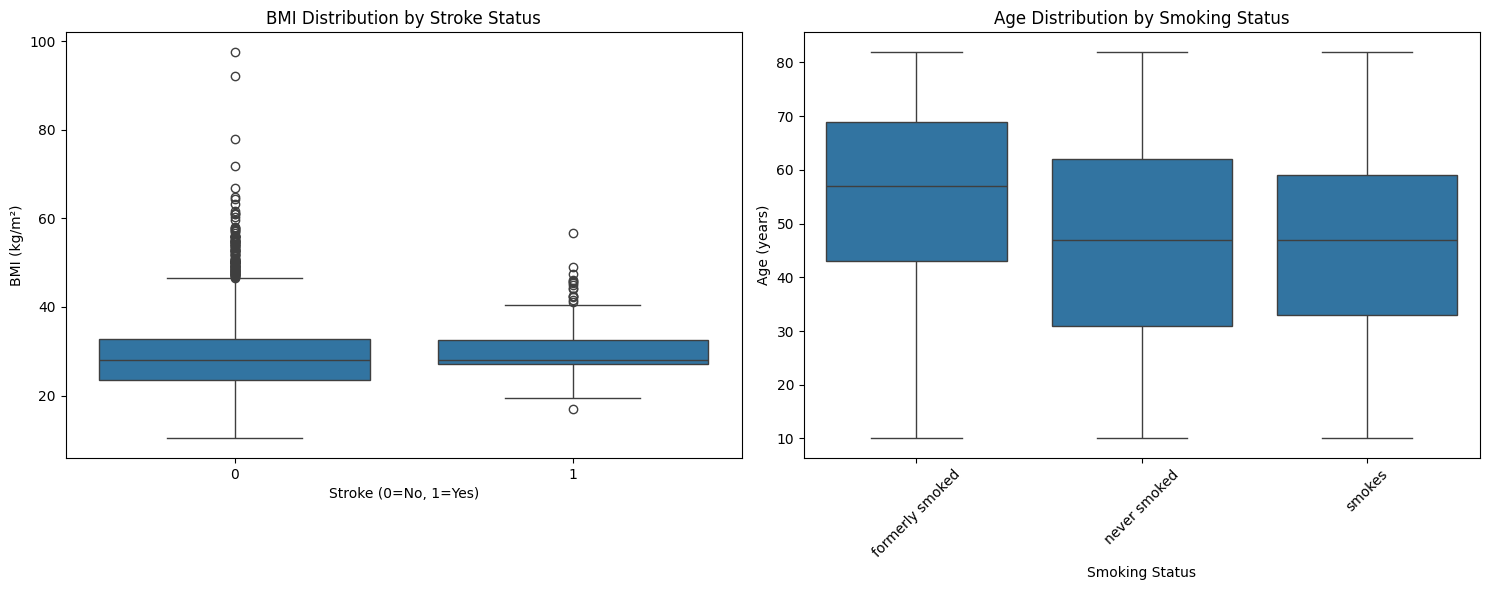

Plots saved as 'stroke_analysis_plots.png'


In [7]:
# Cell 7: Visualizations
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot: BMI by Stroke
sns.boxplot(ax=axes[0], x='stroke', y='bmi', data=df)
axes[0].set_title('BMI Distribution by Stroke Status')
axes[0].set_xlabel('Stroke (0=No, 1=Yes)')
axes[0].set_ylabel('BMI (kg/m²)')

# Boxplot: Age by Smoking Status
sns.boxplot(ax=axes[1], x='smoking_status', y='age', data=df_anova)
axes[1].set_title('Age Distribution by Smoking Status')
axes[1].set_xlabel('Smoking Status')
axes[1].set_ylabel('Age (years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('stroke_analysis_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved as 'stroke_analysis_plots.png'")

In [8]:
# Cell 8: Save Outputs for Submission
# Save cleaned dataset to Excel with README
output_excel = f"Prejan_CaseStudy.xlsx"
with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='Data', index=False)
    readme_df = pd.DataFrame({
        'Variable': ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                     'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'],
        'Description': ['Unique ID', 'Male/Female', 'Age in years', '1 if hypertensive (0/1)',
                        '1 if heart disease (0/1)', 'Yes/No married', 'Job type (categorical)',
                        'Urban/Rural', 'Average glucose level (mg/dL)', 'BMI (kg/m²)',
                        'Smoking status (never smoked/formerly smoked/smokes/Unknown)', '1 if had stroke (0/1)'],
        'Data Type': ['int', 'str', 'float', 'int', 'int', 'str', 'str', 'str', 'float', 'float', 'str', 'int'],
        'Notes': ['', '', '', '', '', '', '', '', '', 'Imputed missing with median=28.7', 'Excluded Unknown for ANOVA', '']
    })
    readme_df.to_excel(writer, sheet_name='README', index=False)

print(f"Excel file saved: {output_excel}")

# Save results summary to text file (for SPSS comparison or report)
results_txt = f"Prejan_results.txt"
with open(results_txt, 'w') as f:
    f.write("=== Inferential Statistics Results ===\n\n")
    f.write("One-Sample t-Test (Glucose vs 100 mg/dL):\n")
    f.write(f"Mean: {glucose_mean:.2f}, t={t_stat_glucose:.4f}, p={p_val_glucose:.4f}\n")
    f.write(f"95% CI: [{ci_lower_glucose:.2f}, {ci_upper_glucose:.2f}]\n\n")
    f.write("Two-Sample t-Test (BMI: Stroke vs Non-Stroke):\n")
    f.write(f"t={t_stat_bmi:.4f}, p={p_val_bmi:.4f}\n")
    f.write(f"95% CI Diff: [{ci_lower_bmi:.2f}, {ci_upper_bmi:.2f}]\n\n")
    f.write("One-Way ANOVA (Age by Smoking):\n")
    f.write(f"F={f_stat:.2f}, p={p_val_anova:.4f}\n")
    f.write("Group Means: " + str(group_means) + "\n")
    if p_val_anova < 0.05:
        f.write("\nTukey HSD:\n" + str(tukey.summary()) + "\n")

print(f"Results text file saved: {results_txt}")

# Download files (runs in Colab)
files.download(output_excel)
files.download('stroke_analysis_plots.png')
files.download(results_txt)
print("Files downloaded! Ready for submission.")

Excel file saved: [YourName]_CaseStudy.xlsx
Results text file saved: [YourName]_results.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded! Ready for submission.
